In [ ]:
# !pip install iterative-stratification

In [1]:
import os

import numpy as np
import pandas as pd

from collections import Counter
from glob import glob
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from PIL import Image

In [2]:
BRAX_PATH = '/home/brax-pad224'

In [3]:
ERROR_IMAGE_PATH = [
    'images/id_8ddcc9be-390a9d93-f9341a1e-935da254-4434e6d0/Study_37020009.27708770.90607016.06801033.59609128/Series_50091172.61957953.21518934.95057906.24903158/image-98063702-83766554-31030233-96801414-34764732.png',
    'images/id_3e90fd04-31ea9d4e-9452ca96-b12e9769-8db7ae33/Study_85612481.64712378.74145270.71565518.78128013/Series_65483170.57887894.15661685.43930124.26354002/image-86247377-47755007-32980195-97435479-45732711.png',
    'images/id_4f1fc66b-bf98f971-cfed20ec-78f59206-75b5d3a4/Study_53146597.71835202.36010446.07946445.87108878/Series_43104883.52899784.01602198.25729004.91495808/image-83168032-60357736-74953980-34645615-41560556.png',
    'images/id_3e90fd04-31ea9d4e-9452ca96-b12e9769-8db7ae33/Study_85612481.64712378.74145270.71565518.78128013/Series_65483170.57887894.15661685.43930124.26354002/image-74582491-03971018-99886578-52372991-08514123.png',
    'images/id_5355bd5b-c8a3bec1-72f549d7-c2247c11-4c83bc78/Study_16701755.42472975.35153559.83080341.60389356/Series_91400111.78656931.22709214.25315474.30109694/image-41529657-91957979-42710040-09585680-38426061.png',
    'images/id_2ecbab28-396e44bc-67852e5c-1ab73e26-4e076691/Study_75836864.01168078.12981900.31880301.85051894/Series_68306243.02155101.90293285.57537727.11067800/image-20890666-02384573-93522715-18999920-90520206.png',
    'images/id_6e4ed45e-10932870-3ce5f413-b0ad015b-9b4eb111/Study_85584667.30026467.84645337.82041879.60924405/Series_26725032.49985908.41361147.28908418.73650163/image-73409710-96562980-22868388-06861644-51053855.png',
    'images/id_6e4ed45e-10932870-3ce5f413-b0ad015b-9b4eb111/Study_85584667.30026467.84645337.82041879.60924405/Series_47481295.94787708.63898735.25591570.91561070/image-19906308-40192253-16677780-24077923-59766466.png',
    'images/id_a8319cca-34351e63-024eb674-e34030b6-80bb3f40/Study_64491075.55988256.27027861.57546766.84854567/Series_12173925.70934735.79756216.27080791.76608566/image-22690942-78813103-68555148-48389446-07160114.png',
    'images/id_751b6d50-5597bf50-36b607a4-4d3efc57-81f1e96d/Study_97109380.92288149.30810948.96735899.19567855/Series_06951557.48535496.86079608.40561755.56524237/image-98845188-80134780-18569526-32247910-02489022.png'
]

In [ ]:
brax_metadata = pd.read_csv('/home/brax-a-brazilian-labeled-chest-x-ray-dataset-1.1.0/master_spreadsheet_update_labeled.csv')
brax_metadata.head(3)

In [5]:
total_patient_id = Counter(brax_metadata.PatientID.value_counts())
len(total_patient_id)

35

In [6]:
total_patient_id

Counter({64: 1,
         43: 1,
         42: 2,
         41: 1,
         37: 1,
         35: 1,
         34: 1,
         33: 1,
         32: 1,
         28: 2,
         27: 1,
         25: 2,
         24: 1,
         22: 4,
         21: 3,
         20: 2,
         19: 5,
         18: 5,
         17: 5,
         16: 8,
         15: 5,
         14: 10,
         13: 12,
         12: 18,
         11: 21,
         10: 31,
         9: 36,
         8: 68,
         7: 83,
         6: 262,
         5: 192,
         4: 889,
         3: 783,
         2: 12820,
         1: 3164})

In [7]:
total_patient_age = Counter(brax_metadata.PatientAge.values)
total_patient_age

Counter({'40': 3351,
         '45': 3401,
         '50': 2925,
         '25': 1311,
         '85 or more': 2299,
         '30': 1739,
         '70': 2494,
         '35': 2741,
         '60': 3067,
         '55': 3331,
         '65': 2979,
         '0': 3191,
         '75': 2076,
         '15': 866,
         '5': 1674,
         '20': 1164,
         '10': 680,
         '80': 1678})

## #0. Drop Error Images

In [8]:
brax_metadata = brax_metadata[~brax_metadata['PngPath'].isin(ERROR_IMAGE_PATH)]
len(brax_metadata)

40957

## #1. Drop Children Patients

In [ ]:
brax_metadata = brax_metadata[~brax_metadata['PatientAge'].isin(['0', '5', '10', '15'])]
brax_metadata['PatientAge'].value_counts(dropna=False)

## #2. Drop Lateral Images

In [10]:
frontal_metadata = brax_metadata[brax_metadata['Frontal/Lateral'] == 'Frontal']
frontal_metadata['Frontal/Lateral'].value_counts(dropna=False)

Frontal    20355
Name: Frontal/Lateral, dtype: int64

## #3. Check Label Values

### #3-1. Check Classes' Label Distribution

In [ ]:
classes_values = frontal_metadata.loc[:, 'No Finding':'Support Devices']

for column_name in classes_values.columns:
    print(f"========== {column_name} ==========")
    print(frontal_metadata[column_name].value_counts(dropna=False))

In [ ]:
five_classes_values = frontal_metadata.loc[:, ["Cardiomegaly", "Edema", "Consolidation", "Atelectasis", "Pleural Effusion"]]

for column_name in five_classes_values.columns:
    print(f"========== {column_name} ==========")
    print(frontal_metadata[column_name].value_counts(dropna=False))

In [13]:
nan_to_zero = np.nan_to_num(five_classes_values, nan=0)

replaced_nan_to_zero = pd.DataFrame(nan_to_zero, columns=five_classes_values.columns)
replaced_nan_to_zero.value_counts()

Cardiomegaly  Edema  Consolidation  Atelectasis  Pleural Effusion
0.0           0.0    0.0            0.0          0.0                 16619
1.0           0.0    0.0            0.0          0.0                  1137
0.0           0.0    0.0            1.0          0.0                   838
                     1.0            0.0          0.0                   360
1.0           0.0    0.0            1.0          0.0                   312
                                                 1.0                   249
0.0           0.0    0.0            0.0          1.0                   239
1.0           0.0    0.0            0.0          1.0                   164
0.0           0.0    0.0            1.0          1.0                   159
1.0           0.0    1.0            0.0          0.0                    86
0.0           0.0    1.0            1.0          0.0                    65
1.0           0.0    1.0            1.0          0.0                    30
0.0           0.0    1.0          

## #3.2 Get Patient IDs (Edema == Positive)

In [14]:
edema_patient_id = frontal_metadata[frontal_metadata['Edema'] == 1.0]['PatientID'].values
len(edema_patient_id)

25

In [15]:
entire_edema_patient_id = frontal_metadata[frontal_metadata['PatientID'].isin(edema_patient_id)]
len(entire_edema_patient_id)

50

In [ ]:
edema_patient_id_count = sorted(Counter(entire_edema_patient_id['PatientID'].values).items(), key=lambda x: x[1])
edema_patient_id_count

In [17]:
sorted(Counter(entire_edema_patient_id['PatientID'].value_counts()).items(), key=lambda x: x[0])

[(1, 14), (2, 4), (3, 3), (4, 1), (5, 3)]

In [18]:
# Train+Valid: Test = 0.8: 0.2, Train: Valid = 0.8: 0.2
EDEMA_TEST_ID = [x for x, _ in edema_patient_id_count[:5]]
EDEMA_VALID_ID = [x for x, _ in edema_patient_id_count[5:9]]
EDEMA_TRAIN_ID = [x for x, _ in edema_patient_id_count[9:]]
print(len(EDEMA_TEST_ID), len(EDEMA_VALID_ID), len(EDEMA_TRAIN_ID))

5 4 16


## #4. Drop Edema Positive Patients IDs (For Split)

In [19]:
brax_without_edema_pos = brax_metadata[~brax_metadata['PatientID'].isin([x for x, _ in edema_patient_id_count])]
len(brax_without_edema_pos)

34454

In [20]:
frontal_without_edema_pos = brax_without_edema_pos[brax_without_edema_pos['Frontal/Lateral'] == 'Frontal']
frontal_without_edema_pos['Edema'].value_counts(dropna=False)

NaN    20305
Name: Edema, dtype: int64

## #5. Get Patient ID Lists Just Used One

In [21]:
one_patient_id_lists = [patient_id for patient_id, count in frontal_without_edema_pos['PatientID'].value_counts().items() if count == 1]

In [22]:
len(one_patient_id_lists)

13532

In [23]:
one_patient_id_df = frontal_without_edema_pos[frontal_without_edema_pos['PatientID'].isin(one_patient_id_lists)]

In [24]:
print(len(one_patient_id_df))
print(len(frontal_without_edema_pos) - len(one_patient_id_df))

13532
6773


## #6. Split Train, Valid and Test with stratified

In [ ]:
five_classes_values = one_patient_id_df.loc[:, ["Cardiomegaly", "Edema", "Consolidation", "Atelectasis", "Pleural Effusion"]]

for column_name in five_classes_values.columns:
    print(f"========== {column_name} ==========")
    print(one_patient_id_df[column_name].value_counts(dropna=False))

In [26]:
nan_to_zero = np.nan_to_num(five_classes_values, nan=0)

In [28]:
one_patient_id_df.reset_index(drop=True, inplace=True)

In [29]:
mskf = MultilabelStratifiedKFold(n_splits=2, shuffle=False)
train_index, test_index = mskf.split(one_patient_id_df['PatientID'], nan_to_zero)

In [30]:
valid_test_df = one_patient_id_df.iloc[test_index[0], :]

In [31]:
valid_test_label = valid_test_df.loc[:, ["Cardiomegaly", "Edema", "Consolidation", "Atelectasis", "Pleural Effusion"]]
valid_test_label = np.nan_to_num(valid_test_label, nan=0)

In [33]:
valid_index, real_test_index = mskf.split(valid_test_df['PatientID'], valid_test_label)

In [35]:
len(train_index[0]), len(valid_index[0]), len(real_test_index[0])

(6766, 3383, 3383)

In [42]:
TRAIN_FRONTAL_PATIENT_ID = one_patient_id_df.iloc[train_index[0], :]['PatientID'].values
VALID_FRONTAL_PATIENT_ID = valid_test_df.iloc[valid_index[0], :]['PatientID'].values
TEST_FRONTAL_PATIENT_ID = valid_test_df.iloc[real_test_index[0], :]['PatientID'].values

## #7. Get Train, Valid, Test Frontal Patient ID

In [44]:
train_df = frontal_without_edema_pos[~frontal_without_edema_pos['PatientID'].isin(one_patient_id_df['PatientID'].values)]

In [46]:
TRAIN_PATIENT_ID = train_df['PatientID'].values.tolist()
TRAIN_PATIENT_ID += TRAIN_FRONTAL_PATIENT_ID.tolist()
TRAIN_PATIENT_ID += EDEMA_TRAIN_ID

VALID_PATIENT_ID = VALID_FRONTAL_PATIENT_ID.tolist()
VALID_PATIENT_ID += EDEMA_VALID_ID

TEST_PATIENT_ID = TEST_FRONTAL_PATIENT_ID.tolist()
TEST_PATIENT_ID += EDEMA_TEST_ID

In [48]:
len(TRAIN_PATIENT_ID), len(VALID_PATIENT_ID), len(TEST_PATIENT_ID)

(13555, 3387, 3388)

In [49]:
print(round(len(TRAIN_PATIENT_ID) / (len(TRAIN_PATIENT_ID) + len(VALID_PATIENT_ID) + len(TEST_PATIENT_ID)), 2))
print(round(len(VALID_PATIENT_ID) / (len(TRAIN_PATIENT_ID) + len(VALID_PATIENT_ID) + len(TEST_PATIENT_ID)), 2))
print(round(len(TEST_PATIENT_ID) / (len(TRAIN_PATIENT_ID) + len(VALID_PATIENT_ID) + len(TEST_PATIENT_ID)), 2))

0.67
0.17
0.17


## #8. Create Dataframe and Make CSV Files

In [51]:
train_frontal_df = frontal_metadata[frontal_metadata['PatientID'].isin(TRAIN_PATIENT_ID)]
train_frontal_df.reset_index(drop=True, inplace=True)

valid_frontal_df = frontal_metadata[frontal_metadata['PatientID'].isin(VALID_PATIENT_ID)]
valid_frontal_df.reset_index(drop=True, inplace=True)

test_frontal_df = frontal_metadata[frontal_metadata['PatientID'].isin(TEST_PATIENT_ID)]
test_frontal_df.reset_index(drop=True, inplace=True)

print(len(train_frontal_df), len(valid_frontal_df), len(test_frontal_df))

13580 3387 3388


In [63]:
print(round(13580 / (13580 +3387 +3388), 3))
print(round(3387 / (13580 +3387 +3388), 3))
print(round(3388 / (13580 +3387 +3388), 3))

0.667
0.166
0.166


In [62]:
len(frontal_metadata)

20355

In [58]:
check_other = brax_metadata[~brax_metadata['PatientID'].isin(TRAIN_PATIENT_ID)]
check_other = check_other[~check_other['PatientID'].isin(VALID_PATIENT_ID)]
check_other = check_other[~check_other['PatientID'].isin(TEST_PATIENT_ID)]

In [66]:
ONLY_LATERAL_PATIENT_ID = check_other['PatientID'].values

In [70]:
train_df = brax_metadata[brax_metadata['PatientID'].isin(TRAIN_PATIENT_ID + ONLY_LATERAL_PATIENT_ID.tolist())]
train_df.reset_index(drop=True, inplace=True)

valid_df = brax_metadata[brax_metadata['PatientID'].isin(VALID_PATIENT_ID)]
valid_df.reset_index(drop=True, inplace=True)

test_df = brax_metadata[brax_metadata['PatientID'].isin(TEST_PATIENT_ID)]
test_df.reset_index(drop=True, inplace=True)

print(len(train_df), len(valid_df), len(test_df))

22346 6100 6103


In [71]:
print(round(22346 / (22346+ 6100+ 6103), 3))
print(round(6100 / (22346+ 6100+ 6103), 3))
print(round(6103 / (22346+ 6100+ 6103), 3))

0.647
0.177
0.177


In [72]:
len(brax_metadata)

34549

In [73]:
train_df.to_csv('/home/brax-pad224/train_revised.csv', index=False, encoding='cp949')
valid_df.to_csv('/home/brax-pad224/valid_revised.csv', index=False, encoding='cp949')
test_df.to_csv('/home/brax-pad224/test_revised.csv', index=False, encoding='cp949')

## #9. Visualization of Class Distribution

In [74]:
import os
import pandas as pd
from glob import glob
import seaborn as sns
from copy import deepcopy
import math
import random

import numpy as np
from matplotlib import pyplot as plt

In [75]:
target_cols = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

pathology_cols = [v for v in target_cols if v not in ['No Finding', 'Support Devices']]

def calculate_label(df: pd.DataFrame):
    series_nan = df.isnull().sum()
    series_0 = df[df==0].count()
    series_1 = df[df==1].count()
    
    new_df = pd.concat([series_nan, series_0, series_1], axis=1)
    new_df.columns=['NaN', '0', '1']

    # drop if no value in column
    # new_df.drop(columns=new_df.columns[new_df.sum()==0], inplace=True)

    return new_df

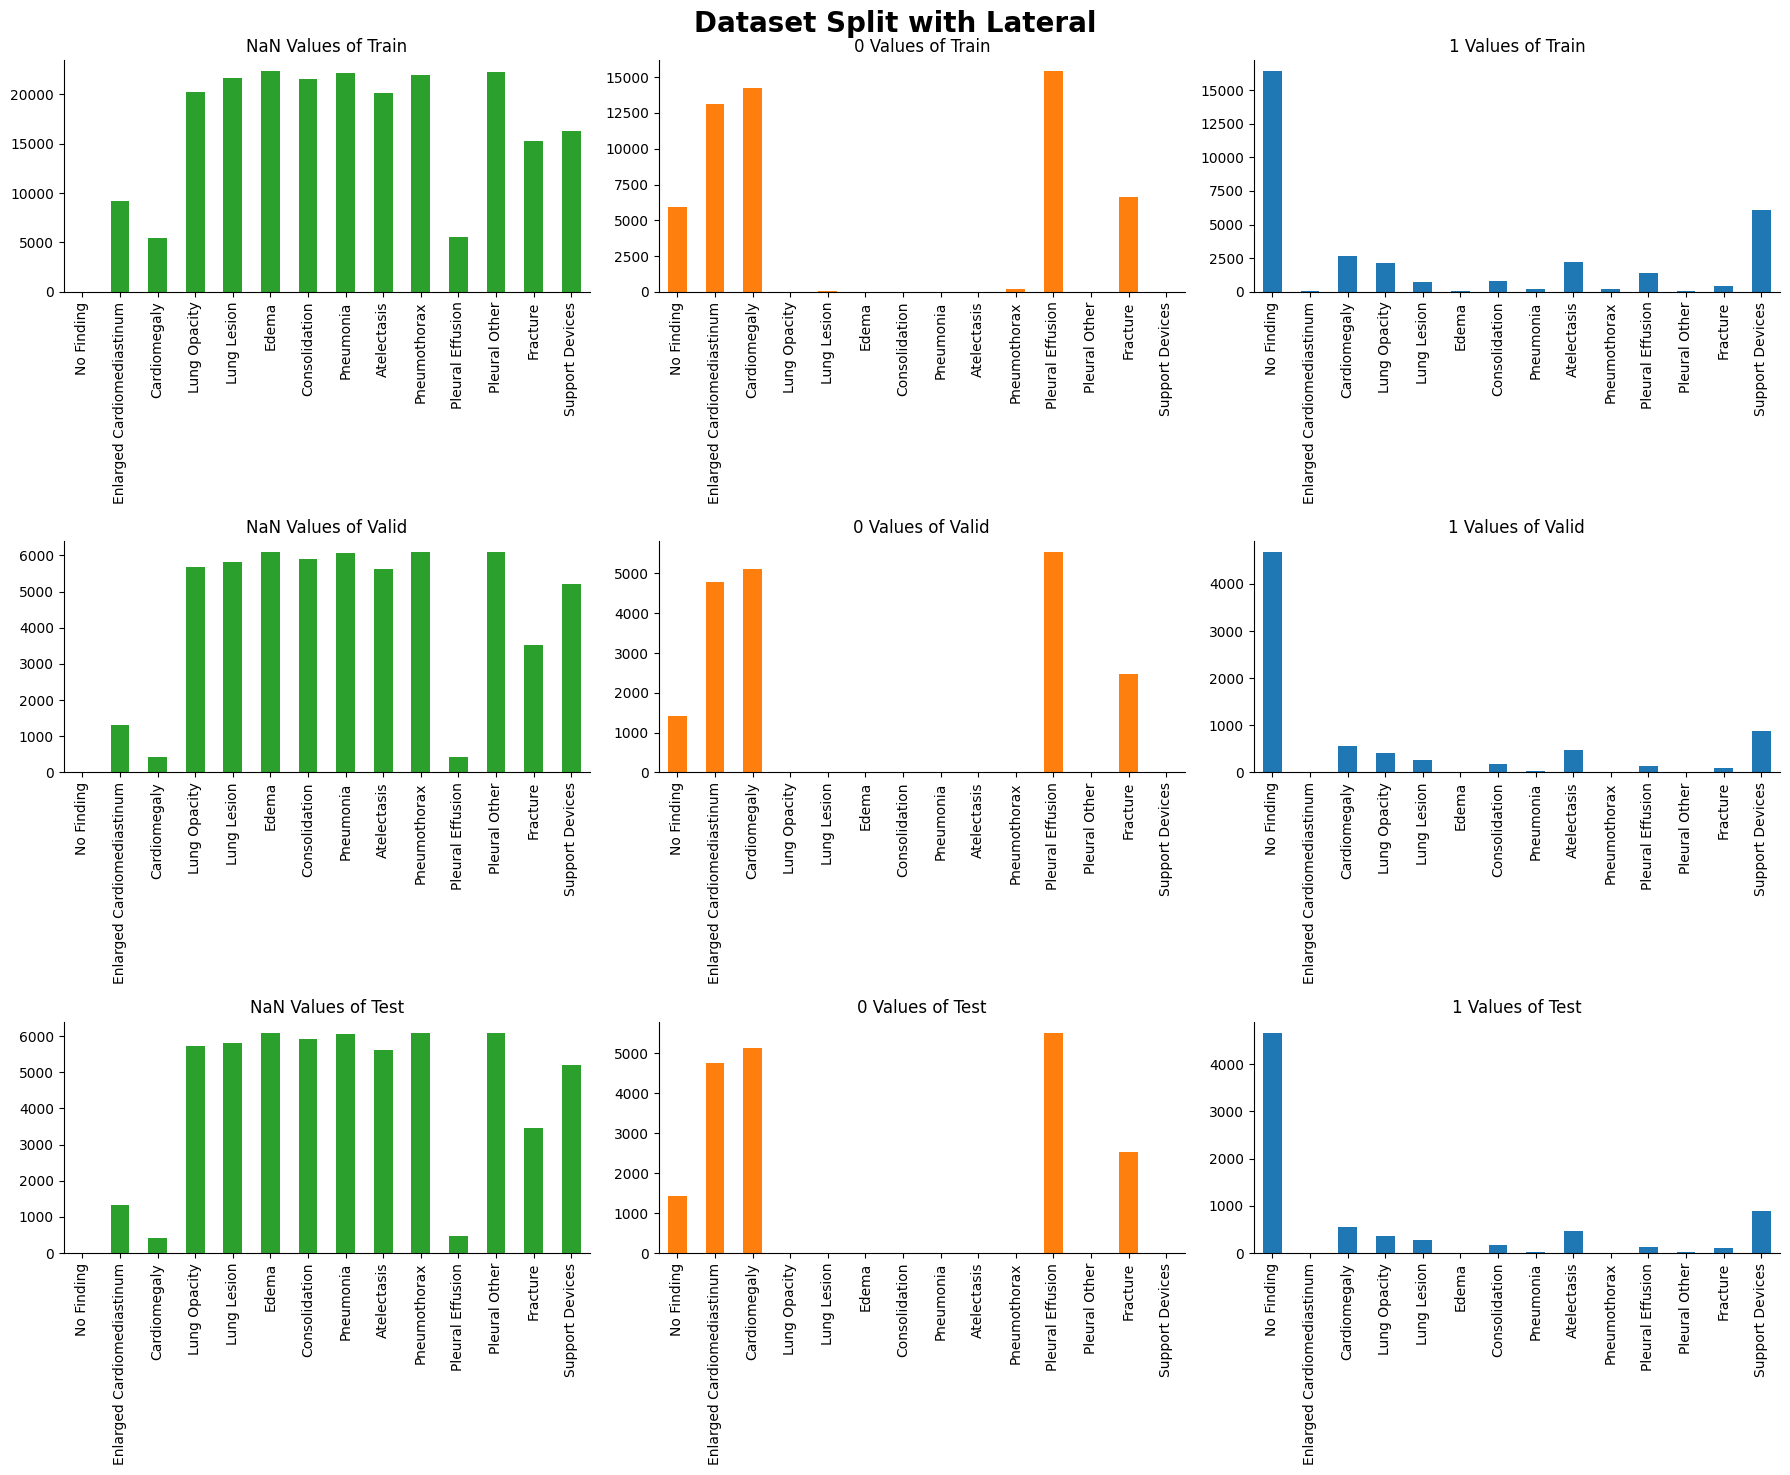

In [76]:
fig_val_sort, ax_val_sort = plt.subplots(3, 3, figsize=(18, 15))

calculate_label(train_df[target_cols])['NaN'].plot(
    kind='bar', ax=ax_val_sort[0][0], color='tab:green', title='NaN Values of Train')
calculate_label(train_df[target_cols])['0'].plot(
    kind='bar', ax=ax_val_sort[0][1], color='tab:orange', title='0 Values of Train')
calculate_label(train_df[target_cols])['1'].plot(
    kind='bar', ax=ax_val_sort[0][2], color='tab:blue', title='1 Values of Train')

calculate_label(valid_df[target_cols])['NaN'].plot(
    kind='bar', ax=ax_val_sort[1][0], color='tab:green', title='NaN Values of Valid')
calculate_label(valid_df[target_cols])['0'].plot(
    kind='bar', ax=ax_val_sort[1][1], color='tab:orange', title='0 Values of Valid')
calculate_label(valid_df[target_cols])['1'].plot(
    kind='bar', ax=ax_val_sort[1][2], color='tab:blue', title='1 Values of Valid')

calculate_label(test_df[target_cols])['NaN'].plot(
    kind='bar', ax=ax_val_sort[2][0], color='tab:green', title='NaN Values of Test')
calculate_label(test_df[target_cols])['0'].plot(
    kind='bar', ax=ax_val_sort[2][1], color='tab:orange', title='0 Values of Test')
calculate_label(test_df[target_cols])['1'].plot(
    kind='bar', ax=ax_val_sort[2][2], color='tab:blue', title='1 Values of Test')

for i in ax_val_sort:
    for ax in i:
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

fig_val_sort.suptitle('Dataset Split with Lateral', fontsize=20, fontweight='bold')
fig_val_sort.tight_layout()

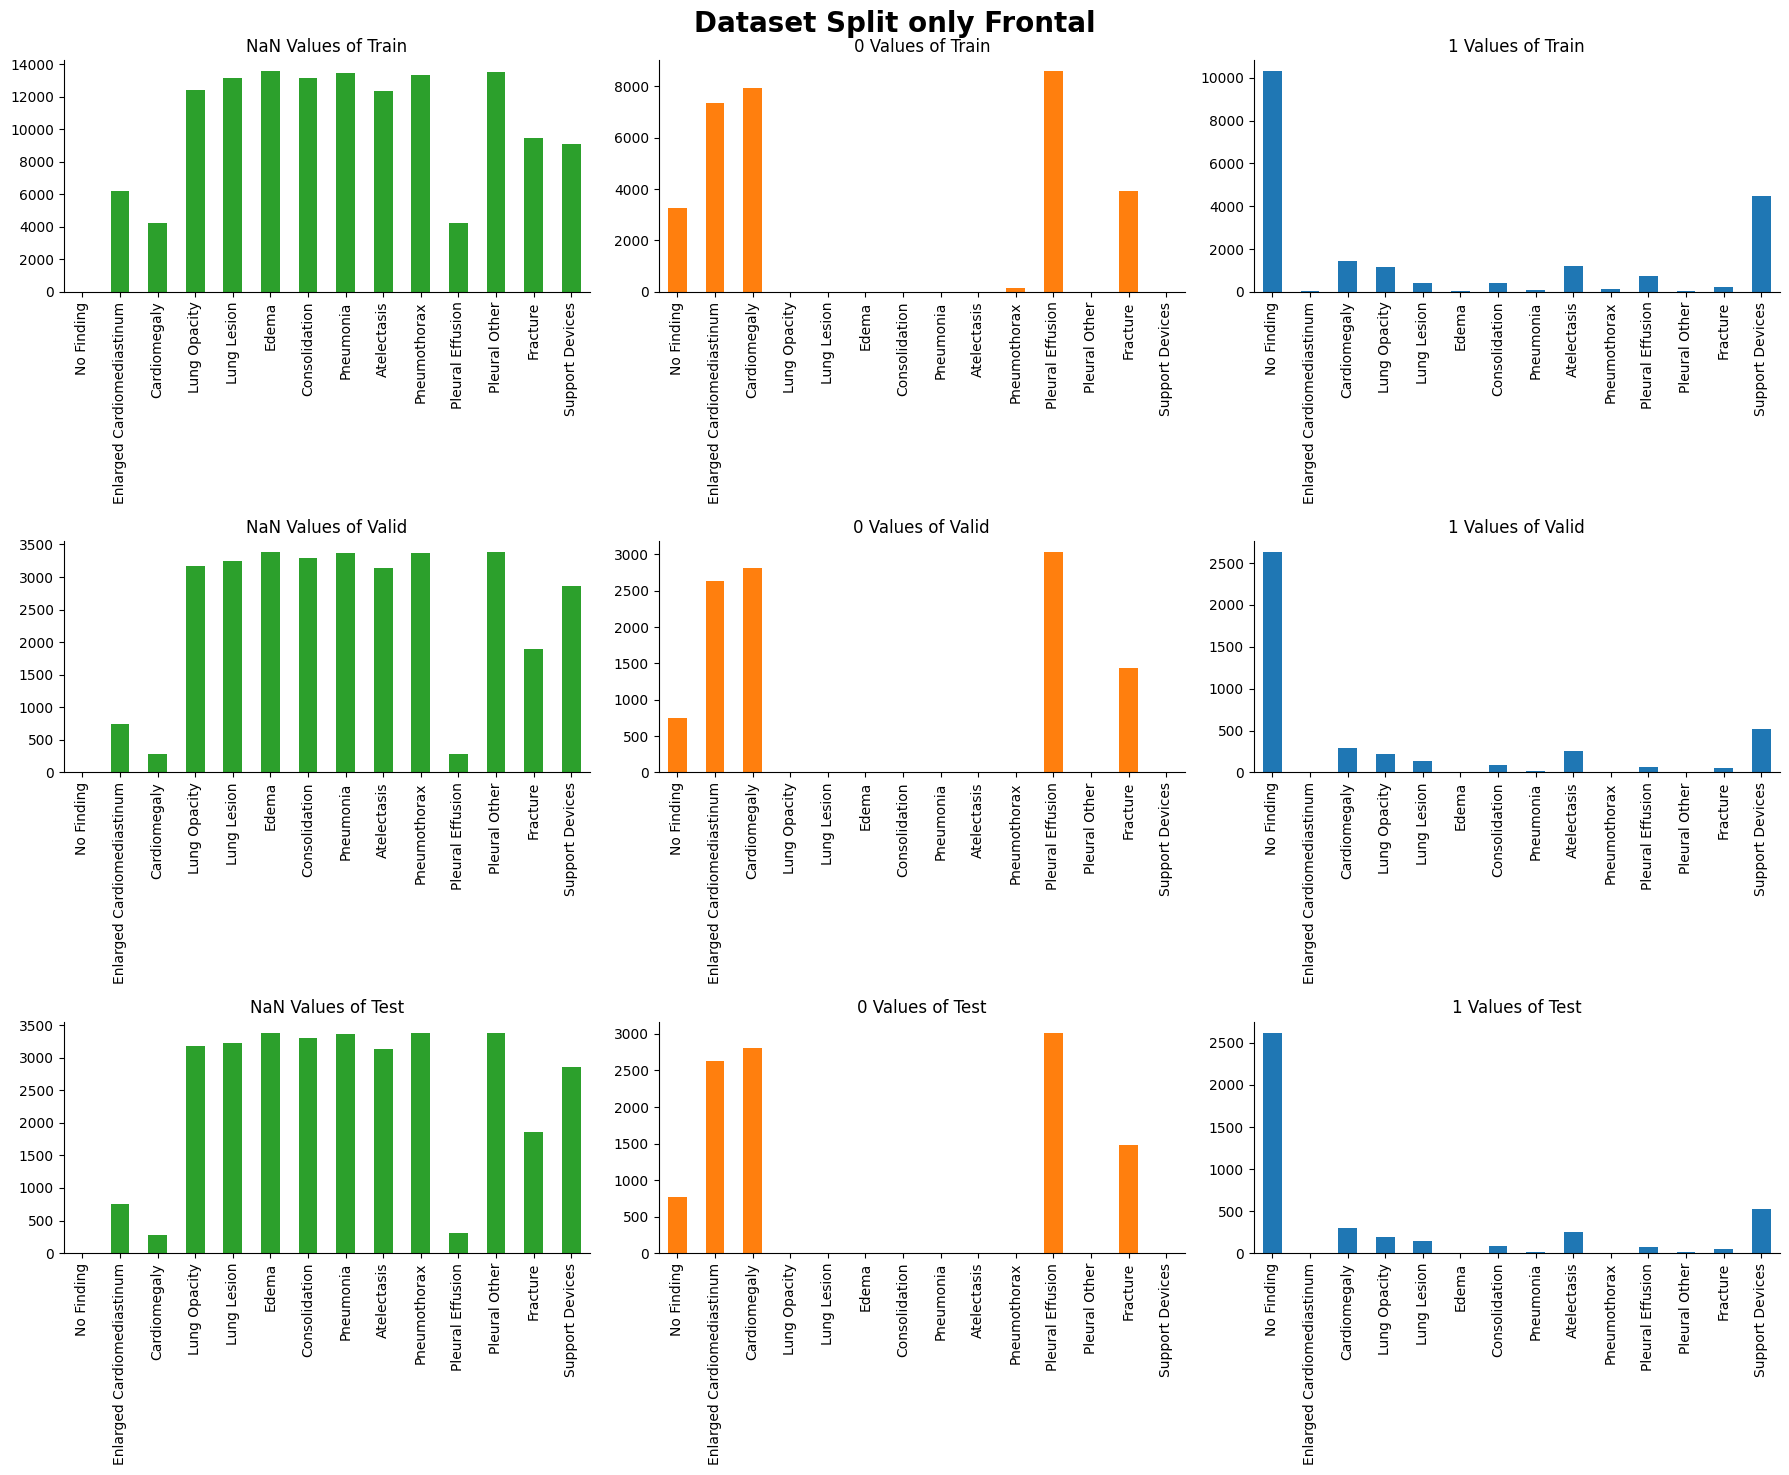

In [77]:
fig_val_sort, ax_val_sort = plt.subplots(3, 3, figsize=(18, 15))

calculate_label(train_frontal_df[target_cols])['NaN'].plot(
    kind='bar', ax=ax_val_sort[0][0], color='tab:green', title='NaN Values of Train')
calculate_label(train_frontal_df[target_cols])['0'].plot(
    kind='bar', ax=ax_val_sort[0][1], color='tab:orange', title='0 Values of Train')
calculate_label(train_frontal_df[target_cols])['1'].plot(
    kind='bar', ax=ax_val_sort[0][2], color='tab:blue', title='1 Values of Train')

calculate_label(valid_frontal_df[target_cols])['NaN'].plot(
    kind='bar', ax=ax_val_sort[1][0], color='tab:green', title='NaN Values of Valid')
calculate_label(valid_frontal_df[target_cols])['0'].plot(
    kind='bar', ax=ax_val_sort[1][1], color='tab:orange', title='0 Values of Valid')
calculate_label(valid_frontal_df[target_cols])['1'].plot(
    kind='bar', ax=ax_val_sort[1][2], color='tab:blue', title='1 Values of Valid')

calculate_label(test_frontal_df[target_cols])['NaN'].plot(
    kind='bar', ax=ax_val_sort[2][0], color='tab:green', title='NaN Values of Test')
calculate_label(test_frontal_df[target_cols])['0'].plot(
    kind='bar', ax=ax_val_sort[2][1], color='tab:orange', title='0 Values of Test')
calculate_label(test_frontal_df[target_cols])['1'].plot(
    kind='bar', ax=ax_val_sort[2][2], color='tab:blue', title='1 Values of Test')

for i in ax_val_sort:
    for ax in i:
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

fig_val_sort.suptitle('Dataset Split only Frontal', fontsize=20, fontweight='bold')
fig_val_sort.tight_layout()

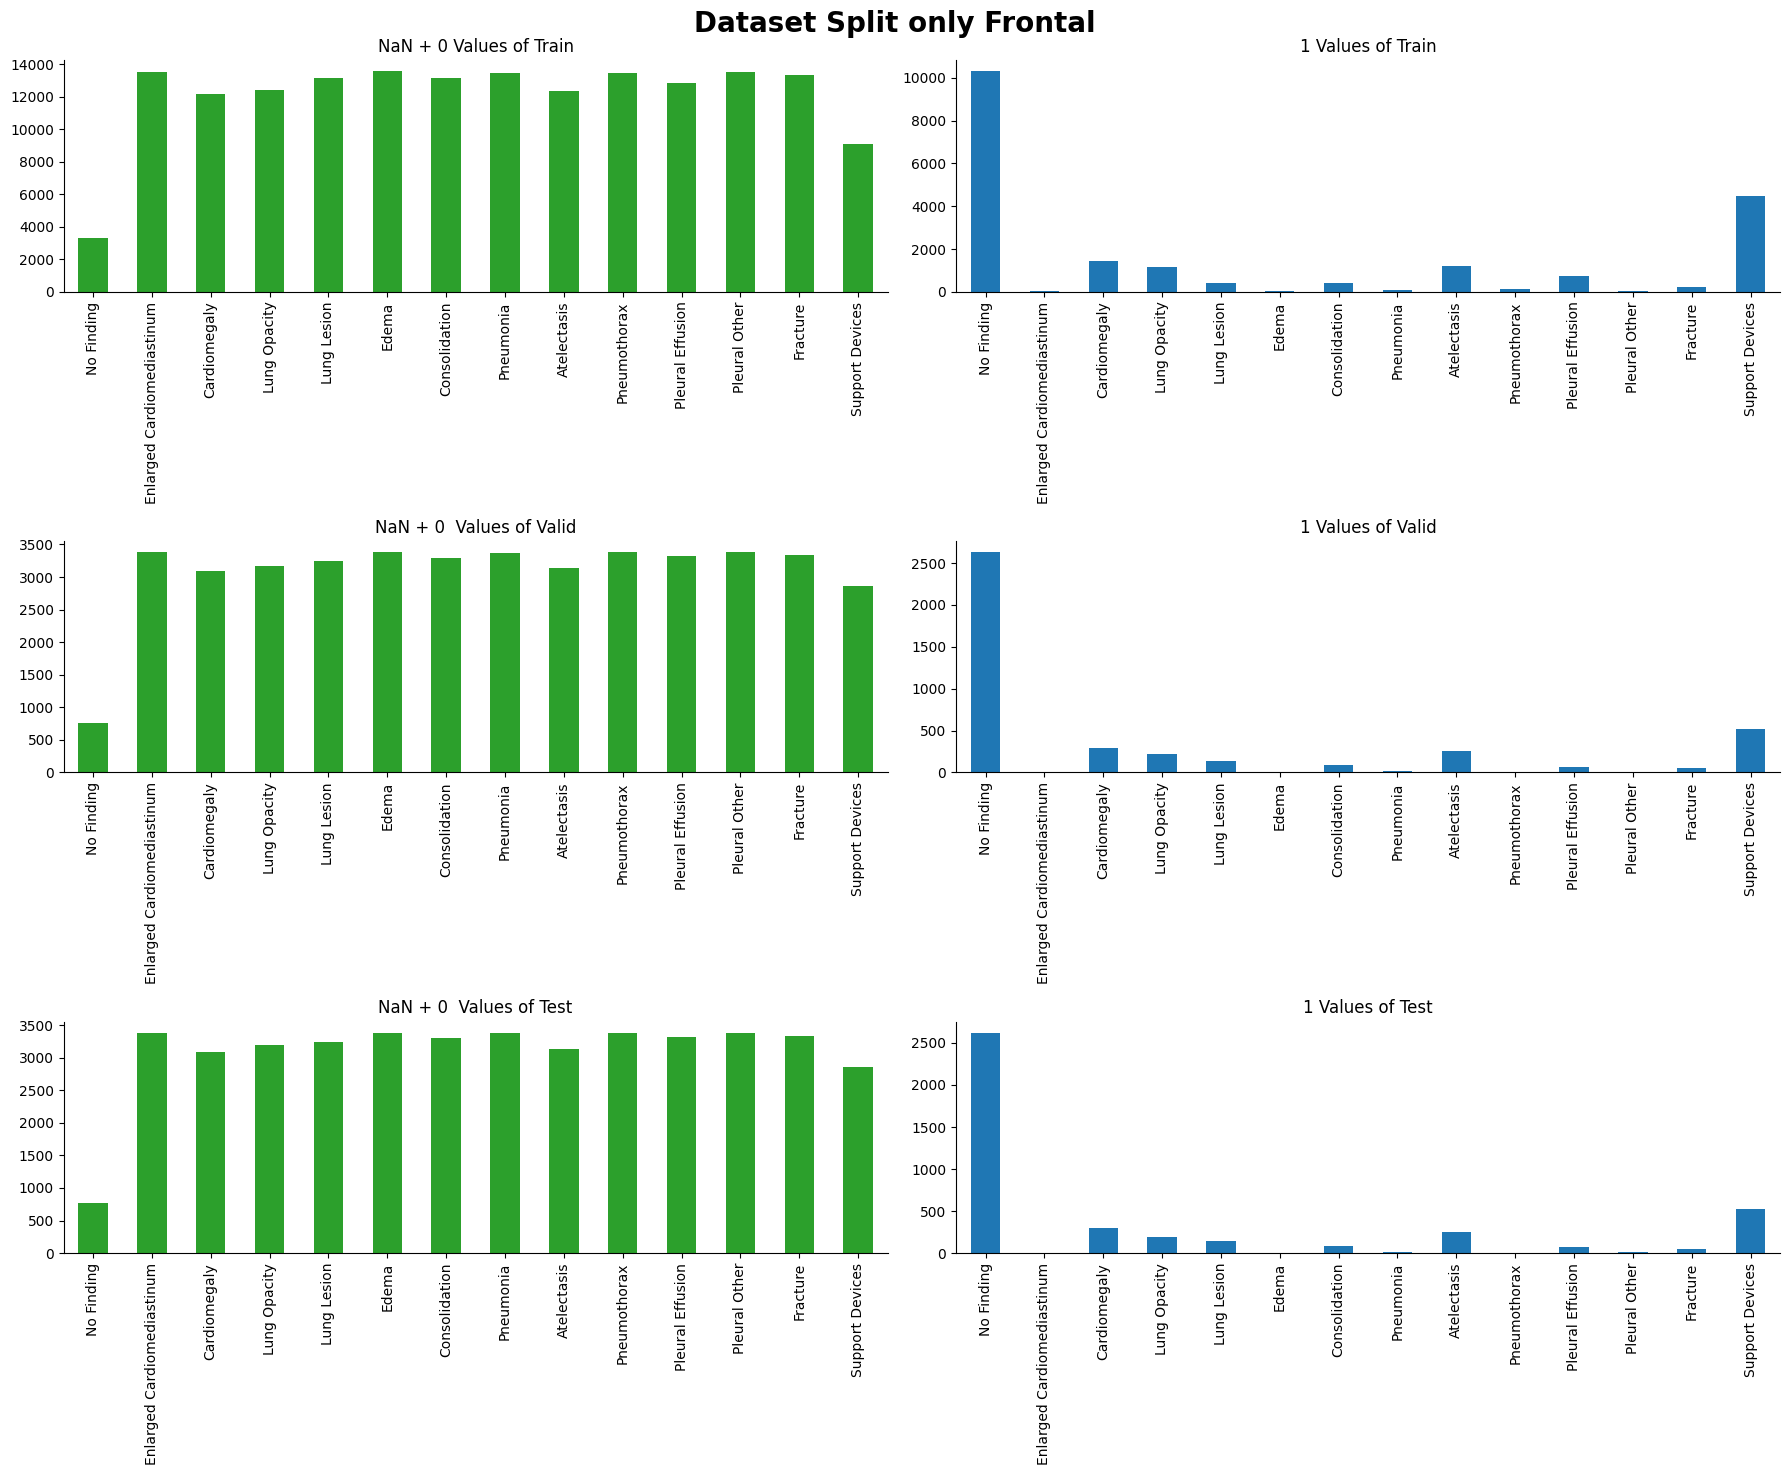

In [79]:
fig_val_sort, ax_val_sort = plt.subplots(3, 2, figsize=(18, 15))

(calculate_label(train_frontal_df[target_cols])['NaN'] + calculate_label(train_frontal_df[target_cols])['0']).plot(
    kind='bar', ax=ax_val_sort[0][0], color='tab:green', title='NaN + 0 Values of Train')
calculate_label(train_frontal_df[target_cols])['1'].plot(
    kind='bar', ax=ax_val_sort[0][1], color='tab:blue', title='1 Values of Train')

(calculate_label(valid_frontal_df[target_cols])['NaN'] + calculate_label(valid_frontal_df[target_cols])['0']).plot(
    kind='bar', ax=ax_val_sort[1][0], color='tab:green', title='NaN + 0  Values of Valid')
calculate_label(valid_frontal_df[target_cols])['1'].plot(
    kind='bar', ax=ax_val_sort[1][1], color='tab:blue', title='1 Values of Valid')

(calculate_label(test_frontal_df[target_cols])['NaN'] + calculate_label(test_frontal_df[target_cols])['0']).plot(
    kind='bar', ax=ax_val_sort[2][0], color='tab:green', title='NaN + 0  Values of Test')
calculate_label(test_frontal_df[target_cols])['1'].plot(
    kind='bar', ax=ax_val_sort[2][1], color='tab:blue', title='1 Values of Test')

for i in ax_val_sort:
    for ax in i:
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)

fig_val_sort.suptitle('Dataset Split only Frontal', fontsize=20, fontweight='bold')
fig_val_sort.tight_layout()